In [1]:
import pandas as pd
import numpy as np

np.random.seed(42)
n = 1000

departamentos = ['Ventas', 'IT', 'RRHH', 'Finanzas', 'Marketing', 'Producción', 'Legal']
sedes = ['Madrid', 'Barcelona', 'Bilbao', 'Valencia', 'Málaga']

data = pd.DataFrame({
    'edad': np.random.randint(21, 65, n),
    'antigüedad': np.round(np.random.exponential(scale=5, size=n), 1),
    'salario': np.random.normal(33000, 9000, n).astype(int),
    'promociones': np.random.poisson(0.3, n),
    'formaciones': np.random.randint(0, 6, n),
    'ausencias': np.random.poisson(5, n),
    'trabajo_remoto': np.random.choice([0, 1], n, p=[0.6, 0.4]),
    'departamento': np.random.choice(departamentos, n),
    'sede': np.random.choice(sedes, n),
    'tipo_contrato': np.random.choice(['Indefinido', 'Temporal', 'Prácticas'], n, p=[0.7, 0.25, 0.05]),
    'evaluacion_desempeño': np.round(np.random.normal(3, 0.8, n), 2),
})

# Contratos temporales de más de 1 año se transforman a indefinidos
data.loc[(data['tipo_contrato'] == 'Temporal') & (data['antigüedad'] > 1), 'tipo_contrato'] = 'Indefinido'

# Cálculo del nivel de satisfacción laboral estimado. Se combinan múltiples factores como desempeño, 
# promociones, ausencias, teletrabajo y formación, ponderados según su posible influencia.
data['satisfaccion'] = (
    0.4 * data['evaluacion_desempeño'] +
    0.3 * (data['promociones'] > 0).astype(int) -
    0.2 * (data['ausencias'] > 7).astype(int) +
    0.1 * data['trabajo_remoto'] +
    0.05 * data['formaciones'] +
    np.random.normal(0, 0.3, n)
)
data['satisfaccion'] = data['satisfaccion'].clip(1, 5)

def calcular_abandono(row):
    score = 0

    # Factores que aumentan la probabilidad de salida
    if row['satisfaccion'] < 2.5:
        score += 1
    if row['antigüedad'] < 1:
        score += 1
    if row['tipo_contrato'] == 'Prácticas':
        score += 1
    if row['tipo_contrato'] == 'Temporal':
        score += 0.5
    if row['evaluacion_desempeño'] < 2.5:
        score += 0.5

# Simulación de decisión de salida con algo de aleatoriedad. La salida incluye un componente aleatorio
# controlado, lo que refleja que, incluso con factores de riesgo, no todos los empleados necesariamente 
# abandonan la organización.
    return 1 if (score >= 1.5 and np.random.rand() < 0.6) else 0

data['se_fue'] = data.apply(calcular_abandono, axis=1)

In [2]:
data.head(10)

,edad,antigüedad,salario,promociones,formaciones,ausencias,trabajo_remoto,departamento,sede,tipo_contrato,evaluacion_desempeño,satisfaccion,se_fue
0,59,4.9,33979,0,4,9,0,RRHH,Madrid,Indefinido,3.17,1.508097,0
1,49,0.6,22932,0,2,2,0,Finanzas,Bilbao,Temporal,2.13,1.439905,1
2,35,14.1,24053,0,3,3,0,Finanzas,Valencia,Indefinido,3.22,2.066400,0
3,63,4.9,32721,1,1,9,0,RRHH,Valencia,Indefinido,4.35,1.848059,0
4,28,2.0,15358,0,3,3,0,Finanzas,Valencia,Indefinido,3.05,1.530424,0
5,41,0.7,51545,0,2,8,0,Legal,Madrid,Indefinido,2.98,1.045572,0
6,59,7.9,22262,0,2,5,1,IT,Bilbao,Indefinido,3.68,1.976260,0
7,39,4.8,32639,0,2,4,1,RRHH,Málaga,Indefinido,3.42,1.813907,0
8,43,3.8,43513,1,5,9,1,RRHH,Málaga,Indefinido,2.08,1.083838,0
9,31,11.2,25233,0,0,2,0,IT,Barcelona,Indefinido,2.64,1.000000,0


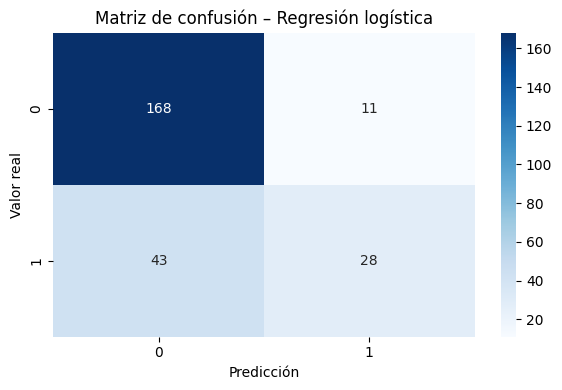


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       179
           1       0.72      0.39      0.51        71

    accuracy                           0.78       250
   macro avg       0.76      0.67      0.69       250
weighted avg       0.77      0.78      0.76       250


ROC AUC Score: 0.798


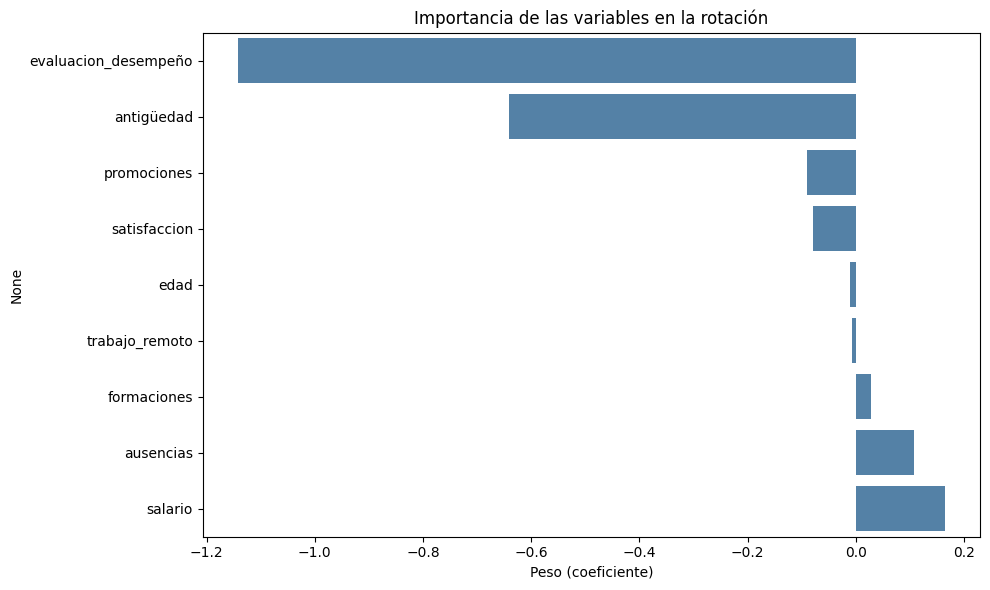

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns

# Selección de variables
features = [
    'edad', 'antigüedad', 'salario', 'promociones', 'formaciones',
    'ausencias', 'trabajo_remoto', 'evaluacion_desempeño',
    'satisfaccion'
]
X = data[features]
y = data['se_fue']

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División entrenamiento / test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42
)

# Entrenamiento del modelo
modelo = LogisticRegression(max_iter=2000)
modelo.fit(X_train, y_train)

# Predicciones
y_pred = modelo.predict(X_test)
y_prob = modelo.predict_proba(X_test)[:, 1]

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
labels = modelo.classes_

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión – Regresión logística')
plt.tight_layout()
plt.show()

# Reporte de evaluación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:", round(roc_auc_score(y_test, y_prob), 3))

# Importancia de variables (coeficientes)
importancia = pd.Series(modelo.coef_[0], index=features).sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(
    x=importancia.values,
    y=importancia.index,
    color="steelblue"
)
plt.title("Importancia de las variables en la rotación")
plt.xlabel("Peso (coeficiente)")
plt.tight_layout()
plt.show()

# Aplicación del modelo al conjunto completo
data['riesgo_abandono'] = modelo.predict_proba(scaler.transform(data[features]))[:, 1]

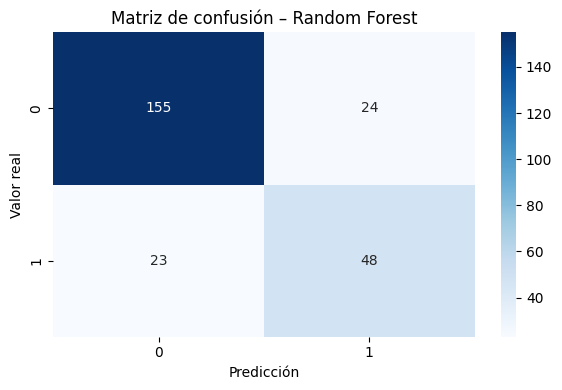


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       179
           1       0.67      0.68      0.67        71

    accuracy                           0.81       250
   macro avg       0.77      0.77      0.77       250
weighted avg       0.81      0.81      0.81       250


ROC AUC Score: 0.857


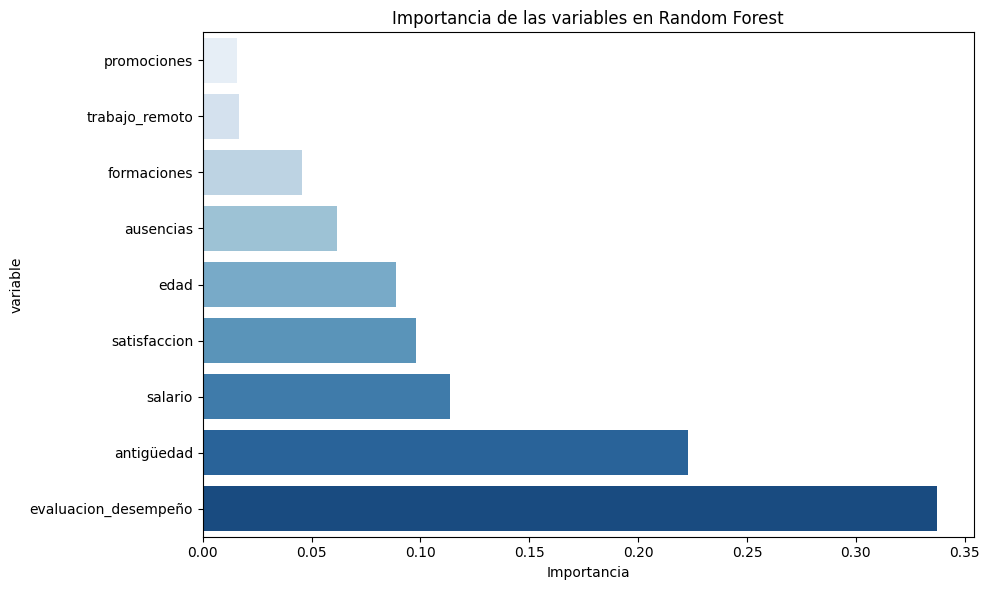

In [4]:
from sklearn.ensemble import RandomForestClassifier

# Variables de entrada y salida
features = [
    'edad', 'antigüedad', 'salario', 'promociones', 'formaciones',
    'ausencias', 'trabajo_remoto', 'evaluacion_desempeño', 'satisfaccion'
]
X = data[features]
y = data['se_fue']

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Modelo Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)

# Predicciones
y_pred = modelo_rf.predict(X_test)
y_prob = modelo_rf.predict_proba(X_test)[:, 1]

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
labels = modelo_rf.classes_

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión – Random Forest')
plt.tight_layout()
plt.show()

# Reporte de evaluación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

print("\nROC AUC Score:", round(roc_auc_score(y_test, y_prob), 3))

# Importancia de variables
importancia = pd.Series(modelo_rf.feature_importances_, index=features).sort_values()
df_importancia = importancia.reset_index()
df_importancia.columns = ['variable', 'importancia']

plt.figure(figsize=(10, 6))
sns.barplot(
    x='importancia',
    y='variable',
    data=df_importancia,
    hue='variable',
    palette='Blues',
    legend=False
)
plt.title("Importancia de las variables en Random Forest")
plt.xlabel("Importancia")
plt.tight_layout()
plt.show()

# Riesgo de abandono estimado (población completa)
data['riesgo_abandono'] = modelo_rf.predict_proba(data[features])[:, 1]

In [5]:
# Variables predictoras
features = [
    'edad', 'antigüedad', 'salario', 'promociones', 'formaciones',
    'ausencias', 'trabajo_remoto', 'evaluacion_desempeño', 'satisfaccion'
]
X = data[features]
y = data['se_fue']

# Aunque Gradient Boosting no requiere escalado, se aplica aquí por consistencia con modelos anteriores 
# y para facilitar posibles comparaciones con modelos sensibles a la escala de los datos.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División entrenamiento/prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

In [6]:
from sklearn.metrics import recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

modelos = {
    'Regresión logística': LogisticRegression(max_iter=1000),
    'Árbol de decisión': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100)
}

resultados = []

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1]

    resultados.append({
        'Modelo': nombre,
        'Precisión': round(modelo.score(X_test, y_test), 3),
        'Recall (salida)': round(recall := recall_score(y_test, y_pred), 3),
        'F1-Score': round(f1 := f1_score(y_test, y_pred), 3),
        'AUC': round(roc_auc_score(y_test, y_prob), 3)
    })

df_resultados = pd.DataFrame(resultados).sort_values('AUC', ascending=False)
print(df_resultados)

                Modelo  Precisión  Recall (salida)  F1-Score    AUC
3    Gradient Boosting      0.836            0.690     0.705  0.867
2        Random Forest      0.804            0.662     0.657  0.859
0  Regresión logística      0.784            0.394     0.509  0.798
1    Árbol de decisión      0.780            0.606     0.610  0.727


In [7]:
from sklearn.model_selection import GridSearchCV

# Definimos el espacio de búsqueda
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

gb = GradientBoostingClassifier(random_state=42)
grid = GridSearchCV(estimator=gb, param_grid=param_grid, 
                    cv=5, scoring='f1', n_jobs=-1, verbose=1)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1.0]},
             scoring='f1', verbose=1)

Mejores hiperparámetros: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


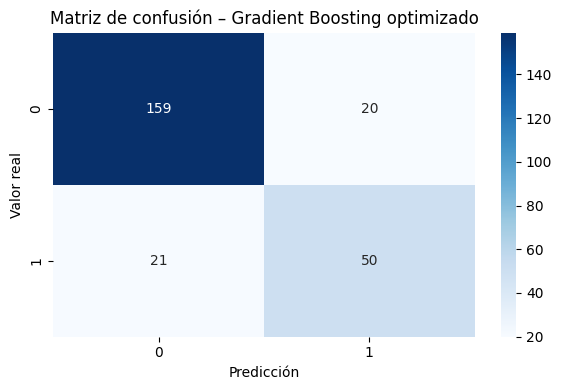


Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       179
           1       0.71      0.70      0.71        71

    accuracy                           0.84       250
   macro avg       0.80      0.80      0.80       250
weighted avg       0.84      0.84      0.84       250

ROC AUC Score: 0.866


In [8]:
# Obtener el mejor modelo de GridSearchCV
mejor_modelo = grid.best_estimator_

# Predicciones
y_pred = mejor_modelo.predict(X_test)
y_prob = mejor_modelo.predict_proba(X_test)[:, 1]

# Mostrar mejores hiperparámetros
print("Mejores hiperparámetros:", grid.best_params_)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
labels = mejor_modelo.classes_

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel('Predicción')
plt.ylabel('Valor real')
plt.title('Matriz de confusión – Gradient Boosting optimizado')
plt.tight_layout()
plt.show()

# Reporte de clasificación
print("\nReporte de clasificación:")
print(classification_report(y_test, y_pred))

# AUC
print("ROC AUC Score:", round(roc_auc_score(y_test, y_prob), 3))

In [9]:
# Aplicamos el mejor modelo al conjunto completo
data['riesgo_abandono'] = mejor_modelo.predict_proba(X_scaled)[:, 1]

## ¿Quiénes están en mayor riesgo ahora mismo? ##

In [10]:
# Ordenamos por mayor riesgo de abandono
top_10 = data.sort_values('riesgo_abandono', ascending=False).head(int(0.10 * len(data)))

# Seleccionamos columnas relevantes
columnas_clave = [
    'edad', 'antigüedad', 'sede', 'departamento',
    'tipo_contrato', 'satisfaccion', 'evaluacion_desempeño',
    'trabajo_remoto', 'riesgo_abandono'
]

# Mostramos la tabla priorizada
top_10_empleados = top_10[columnas_clave]
top_10_empleados.head(10) 

,edad,antigüedad,sede,departamento,tipo_contrato,satisfaccion,evaluacion_desempeño,trabajo_remoto,riesgo_abandono
377,22,0.5,Barcelona,Ventas,Temporal,1.391470,3.34,0,0.922340
690,61,5.6,Barcelona,Ventas,Indefinido,1.000000,0.78,0,0.914072
544,51,5.8,Barcelona,Ventas,Indefinido,1.000000,1.12,0,0.908220
119,47,9.9,Valencia,Marketing,Indefinido,1.000000,1.39,1,0.895307
732,37,0.6,Madrid,Producción,Indefinido,1.612837,2.18,0,0.886946
900,50,6.2,Madrid,Finanzas,Indefinido,1.000000,1.27,0,0.874259
255,21,8.2,Valencia,RRHH,Indefinido,1.101550,0.83,1,0.873151
821,34,4.4,Barcelona,Ventas,Indefinido,1.000000,0.96,1,0.870283
673,22,0.2,Barcelona,Legal,Temporal,1.318227,3.70,1,0.867852
294,28,4.9,Barcelona,RRHH,Indefinido,1.000000,0.75,1,0.857124


## Visualización por sede en orden ascendente ##

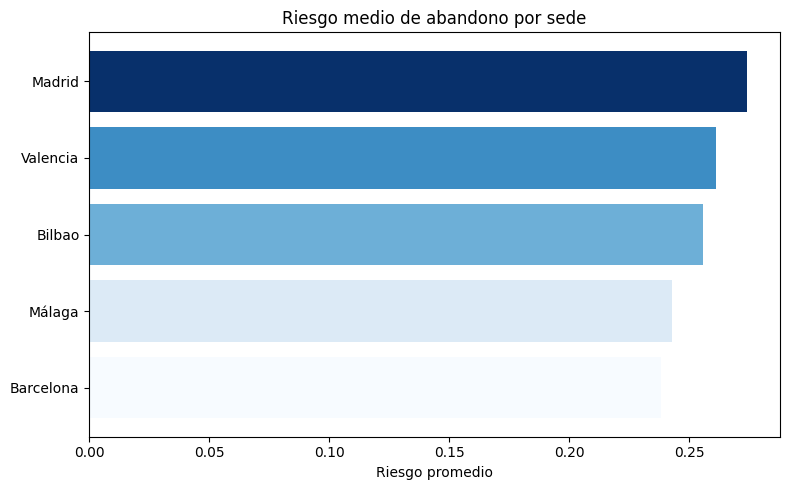

In [11]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Agrupamos por sede para calcular el riesgo medio
df_sedes = data.groupby('sede', as_index=False)['riesgo_abandono'].mean()
df_sedes = df_sedes.rename(columns={'riesgo_abandono': 'riesgo'})

# Ordenamos de menor a mayor riesgo
df_sedes = df_sedes.sort_values(by='riesgo', ascending=True).reset_index(drop=True)

# Normalizamos el color
norm = mcolors.Normalize(vmin=df_sedes['riesgo'].min(), vmax=df_sedes['riesgo'].max())
cmap = cm.Blues  # Cambiado de Reds → Blues

# Gráfico limpio y ordenado
plt.figure(figsize=(8, 5))
for i, (sede, riesgo) in enumerate(zip(df_sedes['sede'], df_sedes['riesgo'])):
    plt.barh(
        y=i,
        width=riesgo,
        color=cmap(norm(riesgo))
    )

plt.yticks(ticks=range(len(df_sedes)), labels=df_sedes['sede'])
plt.xlabel("Riesgo promedio")
plt.title("Riesgo medio de abandono por sede")
plt.tight_layout()
plt.show()

## Visualización del riesgo medio por tipo de contrato ##

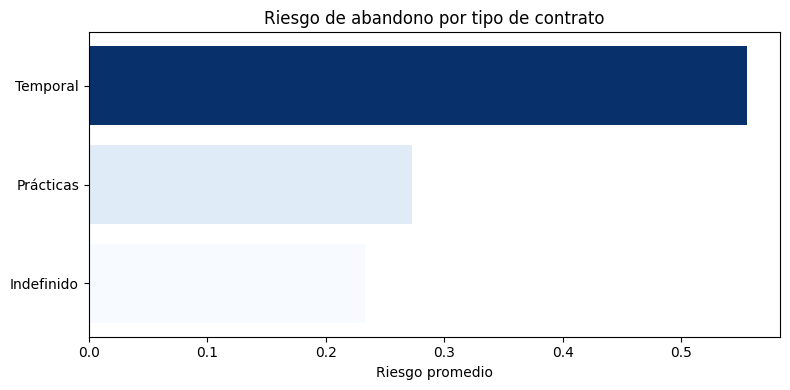

In [12]:
# Agrupamos y ordenamos
riesgo_contrato = data.groupby('tipo_contrato')['riesgo_abandono'].mean().sort_values(ascending=True).reset_index()
riesgo_contrato.columns = ['tipo_contrato', 'riesgo']

# Normalización y escala de color azul
norm = mcolors.Normalize(vmin=riesgo_contrato['riesgo'].min(), vmax=riesgo_contrato['riesgo'].max())
cmap = cm.Blues  # Cambiado de OrRd → Blues

# Gráfico horizontal coloreado por intensidad de riesgo
plt.figure(figsize=(8, 4))
for i, (contrato, riesgo) in enumerate(zip(riesgo_contrato['tipo_contrato'], riesgo_contrato['riesgo'])):
    plt.barh(
        y=i,
        width=riesgo,
        color=cmap(norm(riesgo))
    )

plt.yticks(ticks=range(len(riesgo_contrato)), labels=riesgo_contrato['tipo_contrato'])
plt.xlabel("Riesgo promedio")
plt.title("Riesgo de abandono por tipo de contrato")
plt.tight_layout()
plt.show()

## Visualización del riesgo de abandono por departamento ##

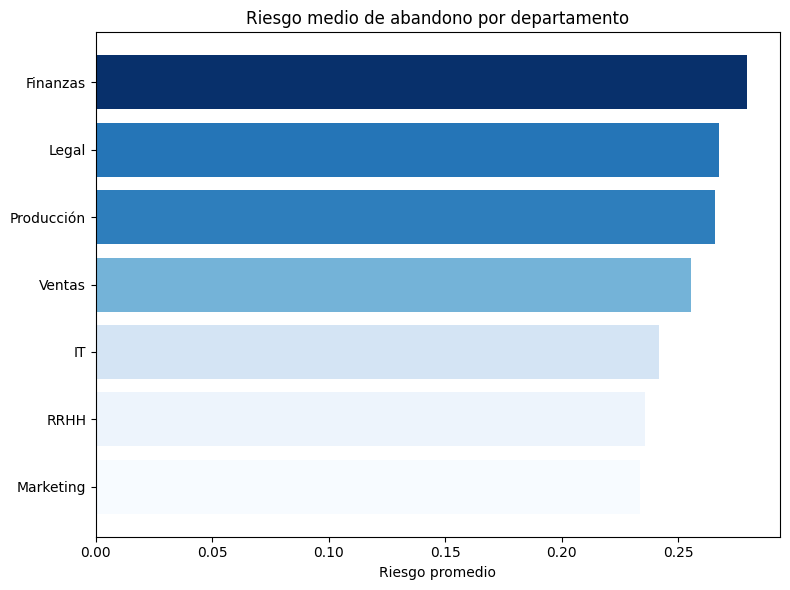

In [13]:
# Agrupamiento y orden
riesgo_depto = data.groupby('departamento')['riesgo_abandono'].mean().sort_values(ascending=True).reset_index()
riesgo_depto.columns = ['departamento', 'riesgo']

# Normalización para asignar color proporcional
norm = mcolors.Normalize(vmin=riesgo_depto['riesgo'].min(), vmax=riesgo_depto['riesgo'].max())
cmap = cm.Blues  # Sustituimos Reds → Blues 💙

# Visualización horizontal con intensidad azul
plt.figure(figsize=(8, 6))
for i, (depto, riesgo) in enumerate(zip(riesgo_depto['departamento'], riesgo_depto['riesgo'])):
    plt.barh(
        y=i,
        width=riesgo,
        color=cmap(norm(riesgo))
    )

plt.yticks(ticks=range(len(riesgo_depto)), labels=riesgo_depto['departamento'])
plt.xlabel("Riesgo promedio")
plt.title("Riesgo medio de abandono por departamento")
plt.tight_layout()
plt.show()


## ¿Dónde se está concentrando el riesgo estructural? ##

In [14]:
# Calculamos el riesgo medio y el tamaño del grupo por combinación
tabla_riesgo = (
    data.groupby(['sede', 'departamento', 'tipo_contrato'])
    .agg(
        riesgo_promedio=('riesgo_abandono', 'mean'),
        total_empleados=('riesgo_abandono', 'count')
    )
    .reset_index()
)

# Ordenamos de mayor a menor riesgo
tabla_riesgo = tabla_riesgo.sort_values(by='riesgo_promedio', ascending=False)

# Mostramos las primeras filas
tabla_riesgo.head(10)


,sede,departamento,tipo_contrato,riesgo_promedio,total_empleados
7,Barcelona,Legal,Temporal,0.850837,2
39,Madrid,IT,Prácticas,0.817122,1
6,Barcelona,Legal,Prácticas,0.764549,1
43,Madrid,Legal,Temporal,0.753100,3
22,Bilbao,IT,Prácticas,0.741230,1
56,Málaga,Finanzas,Temporal,0.722482,3
63,Málaga,Marketing,Temporal,0.697587,2
75,Valencia,IT,Temporal,0.666167,1
35,Bilbao,Ventas,Temporal,0.632427,1
53,Madrid,Ventas,Temporal,0.629609,5
